---

### 🎓 **Professor**: Apostolos Filippas

### 📘 **Class**: AI Engineering

### 📋 **Homework 4**: Embeddings & Semantic Search

### 📅 **Due Date**: Day of Lecture 5, 11:59 PM


**Note**: You are not allowed to share the contents of this notebook with anyone outside this class without written permission by the professor.

---

In this homework, you'll build on Homework 3 (BM25 search) by adding **embedding-based semantic search**.

You will:
1. **Generate embeddings** using both local (Hugging Face) and API (OpenAI) models
2. **Implement cosine similarity** from scratch
3. **Implement semantic search** from scratch
4. **Compare BM25 vs semantic search** using Recall
5. **Compare different embedding models** and analyze their differences

**Total Points: 95**

---

## Instructions

- Complete all tasks by filling in code where you see `# YOUR CODE HERE`
- You may use ChatGPT, Claude, documentation, Stack Overflow, etc.
- When using external resources, briefly cite them in a comment
- Run all cells before submitting to ensure they work

**Submission:**
1. Create a branch called `homework-4`
2. Commit and push your work
3. Create a PR and merge to main
4. Submit the `.ipynb` file on Blackboard

---

## Task 1: Environment Setup (10 points)

### 1a. Imports (5 pts)

Import the required libraries and load the WANDS data.

In [1]:
# ruff: noqa: E402

# Standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import warnings
warnings.filterwarnings("ignore")

# Import ONLY data loading from helpers
import sys
import Stemmer
import string
sys.path.append('../scripts')
from helpers import load_wands_products, load_wands_queries, load_wands_labels

# Embedding libraries - we use these directly
from sentence_transformers import SentenceTransformer
import litellm

# Load environment variables for API keys
from dotenv import load_dotenv
load_dotenv()

pd.set_option('display.max_colwidth', 80)
print("All imports successful!")

All imports successful!


In [2]:
# Load the WANDS dataset
products = load_wands_products()
queries = load_wands_queries()
labels = load_wands_labels()

print(f"Products: {len(products):,}")
print(f"Queries: {len(queries):,}")
print(f"Labels: {len(labels):,}")

Products: 42,994
Queries: 480
Labels: 233,448


### 1b. Copy BM25 functions from HW3 (5 pts)

Copy your BM25 implementation from Homework 3. We'll use it to compare against semantic search.

In [3]:
# Copy your BM25 functions from Homework 3
# Provided functions - run this cell to define them
import Stemmer
stemmer = Stemmer.Stemmer('english')
punct_trans = str.maketrans({key: ' ' for key in string.punctuation})

def snowball_tokenize(text: str) -> list[str]:
    """
    Tokenize text with Snowball stemming.
    
    Args:
        text: The text to tokenize
        
    Returns:
        List of stemmed tokens
    """
    if pd.isna(text) or text is None:
        return []
    text = str(text).translate(punct_trans)
    tokens = text.lower().split()
    return [stemmer.stemWord(token) for token in tokens]

def build_index(docs: list[str], tokenizer) -> tuple[dict, list[int]]:
    """
    Build an inverted index from a list of documents.
    
    Args:
        docs: List of document strings to index
        tokenizer: Function that takes text and returns list of tokens
        
    Returns:
        index: dict mapping term -> {doc_id: term_count}
        doc_lengths: list of document lengths (in tokens)
    """
    index = {}
    doc_lengths = []
    
    for doc_id, doc in enumerate(docs):
        tokens = tokenizer(doc)
        doc_lengths.append(len(tokens))
        term_counts = Counter(tokens)
        
        for term, count in term_counts.items():
            if term not in index:
                index[term] = {}
            index[term][doc_id] = count
    
    return index, doc_lengths

def get_tf(term: str, doc_id: int, index: dict) -> int:
    """
    Get term frequency for a term in a document.
    
    Args:
        term: The term to look up
        doc_id: The document ID
        index: The inverted index
        
    Returns:
        Term frequency (count), or 0 if not found
    """
    if term in index and doc_id in index[term]:
        return index[term][doc_id]
    return 0

def get_df(term: str, index: dict) -> int:
    """
    Get document frequency for a term.
    
    Args:
        term: The term to look up
        index: The inverted index
        
    Returns:
        Number of documents containing the term
    """
    if term in index:
        return len(index[term])
    return 0

def bm25_idf(df: int, num_docs: int) -> float:
    """
    BM25 IDF formula.
    
    Args:
        df: Document frequency
        num_docs: Total number of documents
        
    Returns:
        IDF score
    """
    return np.log((num_docs - df + 0.5) / (df + 0.5) + 1)

def bm25_tf(tf: int, doc_len: int, avg_doc_len: float, k1: float = 1.2, b: float = 0.75) -> float:
    """
    BM25 TF normalization.
    
    Args:
        tf: Term frequency
        doc_len: Document length in tokens
        avg_doc_len: Average document length
        k1: Saturation parameter (default 1.2)
        b: Length normalization (default 0.75)
        
    Returns:
        Normalized TF score
    """
    return (tf * (k1 + 1)) / (tf + k1 * (1 - b + b * doc_len / avg_doc_len))

def score_bm25(query: str, index: dict, num_docs: int, doc_lengths: list[int], 
               tokenizer, k1: float = 1.2, b: float = 0.75) -> np.ndarray:
    """
    Score all documents using BM25.
    
    Args:
        query: The search query
        index: Inverted index
        num_docs: Total number of documents
        doc_lengths: List of document lengths
        tokenizer: Tokenization function
        
    Returns:
        Array of scores for each document
    """
    query_tokens = tokenizer(query)
    scores = np.zeros(num_docs)
    avg_doc_len = np.mean(doc_lengths) if doc_lengths else 1.0
    
    for token in query_tokens:
        df = get_df(token, index)
        if df == 0:
            continue
        
        idf = bm25_idf(df, num_docs)
        
        if token in index:
            for doc_id, tf in index[token].items():
                tf_norm = bm25_tf(tf, doc_lengths[doc_id], avg_doc_len, k1, b)
                scores[doc_id] += idf * tf_norm
    
    return scores

def search_products(query: str, products_df: pd.DataFrame, index: dict, 
                    doc_lengths: list[int], tokenizer, k: int = 10) -> pd.DataFrame:
    """
    Search products and return top-k results.
    
    Args:
        query: The search query
        products_df: DataFrame of products
        index: Inverted index
        doc_lengths: Document lengths
        tokenizer: Tokenization function
        k: Number of results to return
        
    Returns:
        DataFrame with top-k products and scores
    """
    scores = score_bm25(query, index, len(products_df), doc_lengths, tokenizer)
    top_k_idx = np.argsort(-scores)[:k]
    
    results = products_df.iloc[top_k_idx].copy()
    results['score'] = scores[top_k_idx]
    results['rank'] = range(1, k + 1)
    return results

print("All functions defined!")

All functions defined!


---

## Task 2: Understanding Embeddings (15 points)

### 2a. Load a local model and generate embeddings (5 pts)

Use `sentence-transformers` to load a local embedding model and generate embeddings for a list of words.

In [6]:
# Load the all-MiniLM-L6-v2 model using SentenceTransformer

model_name = "all-MiniLM-L6-v2"  # small + fast local model
embed_model = SentenceTransformer(model_name)

words = ["wooden coffee table", "oak dining table", "red leather sofa", "blue area rug", "kitchen sink"]
embeddings = embed_model.encode(words, normalize_embeddings=True)

print("Model:", model_name)
print("Embedding shape:", embeddings.shape)  # (num_words, embedding_dim)

# Show a quick preview
for w, vec in zip(words, embeddings):
    print(w, "->", vec[:5], "...")

Loading weights:   0%|          | 0/103 [00:00<?, ?it/s]

BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Model: all-MiniLM-L6-v2
Embedding shape: (5, 384)
wooden coffee table -> [ 0.0123661   0.02324473 -0.0270216   0.0298118  -0.02943874] ...
oak dining table -> [ 0.03389127  0.01833148 -0.03404869  0.00542756 -0.02827766] ...
red leather sofa -> [ 0.02398181 -0.02086001 -0.04385155  0.01883791  0.00135098] ...
blue area rug -> [0.01870445 0.04514113 0.03994354 0.01917008 0.01463014] ...
kitchen sink -> [-0.00800744  0.00811324  0.01396081  0.02524878 -0.02179149] ...


### 2b. Implement cosine similarity and create a similarity matrix (5 pts)

Implement cosine similarity from scratch:

$$\text{cosine\_similarity}(a, b) = \frac{a \cdot b}{\|a\| \times \|b\|}$$

In [7]:
# Implement cosine similarity from scratch

## Task 2b: Cosine similarity from scratch

def cosine_similarity(a: np.ndarray, b: np.ndarray) -> float:
    """
    Compute cosine similarity between two vectors from scratch.
    """
    dot = np.dot(a, b)
    norm_a = np.sqrt(np.dot(a, a))
    norm_b = np.sqrt(np.dot(b, b))
    
    if norm_a == 0 or norm_b == 0:
        return 0.0
    
    return dot / (norm_a * norm_b)


# Create similarity matrix
n = len(embeddings)
sim_matrix = np.zeros((n, n))

for i in range(n):
    for j in range(n):
        sim_matrix[i, j] = cosine_similarity(embeddings[i], embeddings[j])

# Display as DataFrame
sim_df = pd.DataFrame(sim_matrix, index=words, columns=words)
sim_df



,wooden coffee table,oak dining table,red leather sofa,blue area rug,kitchen sink
wooden coffee table,1.000000,0.588631,0.370622,0.189486,0.295712
oak dining table,0.588631,1.000000,0.337910,0.249521,0.341410
red leather sofa,0.370622,0.337910,1.000000,0.380310,0.057740
blue area rug,0.189486,0.249521,0.380310,1.000000,0.125802
kitchen sink,0.295712,0.341410,0.057740,0.125802,1.000000


### 2c. Embed using OpenAI API (5 pts)

Use `litellm` to get embeddings from OpenAI's API and compare dimensions.

In [9]:
# Use litellm to get an embedding from OpenAI's text-embedding-3-small model
# Task 2c: Embed using OpenAI API (via LiteLLM) and compare dimensions

import os
from litellm import embedding

# 1) Local embedding dimension (from Task 2a)
local_dim = embeddings.shape[1]
print("Local model embedding dim:", local_dim)

# 2) OpenAI embedding via LiteLLM
# Make sure OPENAI_API_KEY is loaded in your environment
print("OPENAI_API_KEY loaded:", bool(os.getenv("OPENAI_API_KEY")))

openai_model = "text-embedding-3-small"
resp = embedding(
    model=openai_model,
    input=words,  # list[str]
)

# LiteLLM returns OpenAI-style response with resp.data[i].embedding
openai_vec0 = resp.data[0]["embedding"]
openai_dim = len(openai_vec0)

print("OpenAI model:", openai_model)
print("OpenAI embedding dim:", openai_dim)
print("Same dimension?", local_dim == openai_dim)


Local model embedding dim: 384
OPENAI_API_KEY loaded: True
OpenAI model: text-embedding-3-small
OpenAI embedding dim: 1536
Same dimension? False


---

## Task 3: Batch Embedding Products (20 points)

### 3a. Embed a product sample (10 pts)

Create a combined text field and embed 5,000 products using the local model.

In [ ]:
# Get a consistent sample
sample_products = products.sample(n=5000, random_state=42).reset_index(drop=True)



In [12]:
# Load local sentence-transformers model
model = SentenceTransformer("all-MiniLM-L6-v2")

print("Local embedding model loaded!")


Loading weights:   0%|          | 0/103 [00:00<?, ?it/s]

BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Local embedding model loaded!


In [13]:
# Create a combined text field (product_name + product_class)
# Then embed all products using model.encode()

# Task 3a: Embed a product sample

sample_products["combined_text"] = (
    sample_products["product_name"].fillna("") + " " +
    sample_products["product_class"].fillna("")
)

print("Sample size:", len(sample_products))
print(sample_products["combined_text"].head())

start = time.time()

embeddings = model.encode(
    sample_products["combined_text"].tolist(),
    show_progress_bar=True
)

end = time.time()

print("Embedding shape:", embeddings.shape)
print(f"Embedding time: {end - start:.2f} seconds")


Sample size: 5000
0                                  woven wire basket Boxes, Bins, Baskets, & Buckets
1                                                scallop nightstand Kids Nightstands
2           ybm home stainless steel colander Strainers, Colanders, & Salad Spinners
3    oneida 2 piece stainless steel strainer set Strainers, Colanders, & Salad Sp...
4                                          ryland platform bed frame Bed Frames|Beds
Name: combined_text, dtype: object


Batches:   0%|          | 0/157 [00:00<?, ?it/s]

Embedding shape: (5000, 384)
Embedding time: 16.12 seconds


### 3b. Save and load embeddings (5 pts)

Save embeddings to a `.npy` file so you don't have to recompute them.

In [14]:
# Save embeddings to ../temp/hw4_embeddings.npy
# Save products_sample to ../temp/hw4_products.csv
# Then load them back and verify they match
import os
import numpy as np

# Create temp directory if it doesn't exist
os.makedirs("../temp", exist_ok=True)

# Save embeddings
np.save("../temp/hw4_embeddings.npy", embeddings)

# Save products sample
sample_products.to_csv("../temp/hw4_products.csv", index=False)

print("Saved embeddings and products!")

# ---- Load back ----

loaded_embeddings = np.load("../temp/hw4_embeddings.npy")
loaded_products = pd.read_csv("../temp/hw4_products.csv")

print("Loaded embeddings shape:", loaded_embeddings.shape)
print("Loaded products rows:", len(loaded_products))

# Verify match
print("Embeddings match:", np.allclose(embeddings, loaded_embeddings))
print("Products match:", sample_products.equals(loaded_products))


Saved embeddings and products!
Loaded embeddings shape: (5000, 384)
Loaded products rows: 5000
Embeddings match: True
Products match: True


### 3c. Cost estimation (5 pts)

Estimate the cost to embed all 43K products using OpenAI's API.

**Pricing**: text-embedding-3-small costs ~$0.02 per 1 million tokens.

In [15]:
# Use tiktoken to count actual tokens in the sample
# Then extrapolate to estimate cost for the full dataset
import tiktoken

# Use OpenAI tokenizer
enc = tiktoken.get_encoding("cl100k_base")

def count_tokens(text):
    return len(enc.encode(text))

# Count tokens for sample
sample_products["token_count"] = sample_products["combined_text"].apply(count_tokens)

total_tokens_sample = sample_products["token_count"].sum()
avg_tokens_per_product = sample_products["token_count"].mean()

print("Total tokens in 5K sample:", total_tokens_sample)
print("Average tokens per product:", avg_tokens_per_product)

# Extrapolate to full dataset (43K products)
num_products_full = len(products)
estimated_total_tokens = avg_tokens_per_product * num_products_full

# Pricing: $0.02 per 1M tokens
cost = (estimated_total_tokens / 1_000_000) * 0.02

print("Estimated total tokens (43K products):", int(estimated_total_tokens))
print(f"Estimated embedding cost: ${cost:.4f}")



Total tokens in 5K sample: 65077
Average tokens per product: 13.0154
Estimated total tokens (43K products): 559584
Estimated embedding cost: $0.0112


---

## Task 4: Semantic Search (25 points)

### 4a. Implement semantic search (15 pts)

Implement a semantic search function from scratch.

In [16]:
# Implement batch cosine similarity for efficiency
import numpy as np
import pandas as pd

def normalize_rows(X: np.ndarray) -> np.ndarray:
    """L2-normalize rows of a matrix."""
    norms = np.linalg.norm(X, axis=1, keepdims=True)
    norms = np.where(norms == 0, 1.0, norms)
    return X / norms

# Normalize product embeddings once for fast cosine sim
product_embs = normalize_rows(loaded_embeddings.astype(np.float32))

def batch_cosine_similarity(query_vec: np.ndarray, doc_matrix: np.ndarray) -> np.ndarray:
    """
    Compute cosine similarity between one query vector and many document vectors.
    Assumes doc_matrix rows are already L2-normalized.
    """
    q = query_vec.astype(np.float32)
    q_norm = np.linalg.norm(q)
    if q_norm == 0:
        return np.zeros(doc_matrix.shape[0], dtype=np.float32)
    q = q / q_norm
    # cosine sim = dot product when both normalized
    return doc_matrix @ q

def semantic_search(query: str, k: int = 10) -> pd.DataFrame:
    """
    Semantic search over the 5K product sample using sentence-transformers embeddings.
    Returns top-k rows from loaded_products with similarity score.
    """
    # Embed query
    q_vec = model.encode([query], normalize_embeddings=False)[0]

    # Compute similarities
    sims = batch_cosine_similarity(q_vec, product_embs)

    # Top-k
    top_idx = np.argsort(-sims)[:k]
    results = loaded_products.iloc[top_idx].copy()
    results["score"] = sims[top_idx]
    results["rank"] = range(1, k + 1)
    results["query"] = query
    return results




In [17]:
# Test semantic search
display(
    semantic_search("star wars rug", k=10)[
        ["rank", "product_id", "product_name", "product_class", "score"]
    ]
)


,rank,product_id,product_name,product_class,score
3013,1,262,jakat gray rug,Area Rugs,0.619081
2116,2,20042,datca shag dark gray area rug,Area Rugs,0.600115
2403,3,39663,melynda gray rug,Area Rugs,0.598825
299,4,13931,surbur gray rug,Area Rugs,0.591038
1545,5,2561,gray rug,Area Rugs,0.585777
1363,6,25707,sulien gray rug,Area Rugs,0.583591
2265,7,10880,harrison power loom gray/red/yellow rug,Area Rugs,0.574896
624,8,31217,alicia carpet khaki area rug,Area Rugs,0.572966
2174,9,38524,raquel tufted rug,Area Rugs,0.571750
1032,10,37296,novelty shayne patchwork cowhide leather gradient gray rug,Area Rugs,0.571298


### 4b. Evaluate and compare BM25 vs semantic search (10 pts)

Implement Recall@k and compare the two search methods.

In [ ]:
# Implement Recall@k
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# -----------------------------
# 1) Recall@k implementation
# -----------------------------
def recall_at_k(retrieved_ids: list[int], relevant_ids: set[int], k: int = 10) -> float:
    """
    Recall@k = (# relevant retrieved in top-k) / (total relevant)
    If there are no relevant docs, return NaN (we'll filter those queries out anyway).
    """
    if not relevant_ids:
        return np.nan
    retrieved_topk = set(retrieved_ids[:k])
    hits = len(retrieved_topk & relevant_ids)
    return hits / len(relevant_ids)



In [20]:
def recall_at_k(retrieved_ids: list[int], relevant_ids: set[int], k: int = 10) -> float:
    if not relevant_ids:
        return np.nan
    retrieved_topk = set(retrieved_ids[:k])
    hits = len(retrieved_topk & relevant_ids)
    return hits / len(relevant_ids)


In [21]:
# Build BM25 index for comparison

# Filter queries to those with products in our sample
# Ensure combined_text exists
from collections import Counter

if "combined_text" not in loaded_products.columns:
    loaded_products["combined_text"] = (
        loaded_products["product_name"].fillna("").astype(str) + " " +
        loaded_products["product_class"].fillna("").astype(str)
    )

sample_docs = loaded_products["combined_text"].fillna("").astype(str).tolist()
bm25_sample_index, bm25_sample_doclens = build_index(sample_docs, snowball_tokenize)

def bm25_search_sample(query: str, k: int = 10) -> pd.DataFrame:
    scores = score_bm25(query, bm25_sample_index, len(loaded_products), bm25_sample_doclens, snowball_tokenize)
    top_idx = np.argsort(-scores)[:k]
    out = loaded_products.iloc[top_idx].copy()
    out["score"] = scores[top_idx]
    out["rank"] = range(1, k + 1)
    return out

print("BM25 sample index built:", len(sample_docs), "docs |", len(bm25_sample_index), "unique terms")

# -----------------------------
# 3) Filter queries to those with relevant products IN our sample
# -----------------------------
sample_product_ids = set(loaded_products["product_id"].astype(int).tolist())

# Define "relevant" as grade > 0 (Exact or Partial)
labels_in_sample = labels[labels["product_id"].isin(sample_product_ids)].copy()
labels_in_sample_relevant = labels_in_sample[labels_in_sample["grade"] > 0].copy()

# relevant set per query_id
relevant_by_query = (
    labels_in_sample_relevant
    .groupby("query_id")["product_id"]
    .apply(lambda s: set(map(int, s.tolist())))
    .to_dict()
)

filtered_queries = queries[queries["query_id"].isin(relevant_by_query.keys())].copy()
print("Total queries:", len(queries))
print("Filtered queries with >=1 relevant product in sample:", len(filtered_queries))

# -----------------------------
# 4) Evaluate Recall@10 for BM25 and Semantic
# -----------------------------
rows = []
K = 10

for _, row in filtered_queries.iterrows():
    qid = int(row["query_id"])
    qtext = row["query"]
    relevant_ids = relevant_by_query[qid]

    # BM25
    bm25_results = bm25_search_sample(qtext, k=K)
    bm25_ids = bm25_results["product_id"].astype(int).tolist()
    bm25_recall = recall_at_k(bm25_ids, relevant_ids, k=K)

    # Semantic
    sem_results = semantic_search(qtext, k=K)
    sem_ids = sem_results["product_id"].astype(int).tolist()
    sem_recall = recall_at_k(sem_ids, relevant_ids, k=K)

    rows.append({
        "query_id": qid,
        "query": qtext,
        "bm25_recall@10": bm25_recall,
        "semantic_recall@10": sem_recall,
        "num_relevant_in_sample": len(relevant_ids),
    })

eval_df = pd.DataFrame(rows)

print("Evaluated queries:", len(eval_df))
print("Mean BM25 Recall@10:", eval_df["bm25_recall@10"].mean())
print("Mean Semantic Recall@10:", eval_df["semantic_recall@10"].mean())

# Show a few where semantic beats BM25 (optional)
display(
    eval_df.assign(diff=eval_df["semantic_recall@10"] - eval_df["bm25_recall@10"])
           .sort_values("diff", ascending=False)
           .head(10)
)





BM25 sample index built: 5000 docs | 5843 unique terms
Total queries: 480
Filtered queries with >=1 relevant product in sample: 471
Evaluated queries: 471
Mean BM25 Recall@10: 0.37246999991695956
Mean Semantic Recall@10: 0.3267054801690032


,query_id,query,bm25_recall@10,semantic_recall@10,num_relevant_in_sample,diff
236,244,pull out sleeper loveseat,0.000000,0.421053,19,0.421053
438,452,day bed indian,0.000000,0.416667,12,0.416667
397,410,pool floats,0.357143,0.714286,14,0.357143
227,235,bathroom wastebasket,0.000000,0.352941,17,0.352941
261,269,donaldson teak couch,0.166667,0.500000,6,0.333333
182,185,lunch bag,0.333333,0.666667,3,0.333333
13,13,outdoor privacy wall,0.000000,0.333333,6,0.333333
141,142,kitchen wooden stand,0.000000,0.333333,6,0.333333
264,272,oliver parsons,0.200000,0.500000,10,0.300000
45,46,beach blue headboard,0.181818,0.454545,11,0.272727


In [ ]:
# Evaluate both BM25 and semantic search on all queries
# Calculate Recall@10 for each method

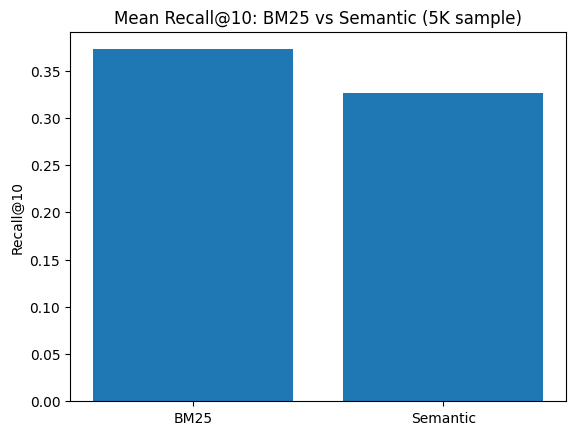

In [22]:
# Visualize comparison

means = eval_df[["bm25_recall@10", "semantic_recall@10"]].mean()

plt.figure()
plt.bar(["BM25", "Semantic"], means.values)
plt.title("Mean Recall@10: BM25 vs Semantic (5K sample)")
plt.ylabel("Recall@10")
plt.show()


---

## Task 5: Compare Embedding Models (20 points)

### 5a. Embed products with two different models (10 pts)

Compare embeddings from:
- `BAAI/bge-base-en-v1.5`
- `sentence-transformers/all-mpnet-base-v2`

In [23]:
# Load the two embedding models
import time
import numpy as np
from sentence_transformers import SentenceTransformer

# Ensure combined_text exists
if "combined_text" not in loaded_products.columns:
    loaded_products["combined_text"] = (
        loaded_products["product_name"].fillna("").astype(str) + " " +
        loaded_products["product_class"].fillna("").astype(str)
    )

texts = loaded_products["combined_text"].fillna("").astype(str).tolist()
print("Docs to embed:", len(texts))

# Load the two embedding models
model_bge = SentenceTransformer("BAAI/bge-base-en-v1.5")
model_mpnet = SentenceTransformer("sentence-transformers/all-mpnet-base-v2")

print("Models loaded.")


Docs to embed: 5000


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/777 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertModel LOAD REPORT from: BAAI/bge-base-en-v1.5
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


tokenizer_config.json:   0%|          | 0.00/366 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

MPNetModel LOAD REPORT from: sentence-transformers/all-mpnet-base-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Models loaded.


In [24]:
# Embed products with both models
start = time.time()
emb_bge = model_bge.encode(texts, show_progress_bar=True, batch_size=64, normalize_embeddings=True)
t_bge = time.time() - start

start = time.time()
emb_mpnet = model_mpnet.encode(texts, show_progress_bar=True, batch_size=64, normalize_embeddings=True)
t_mpnet = time.time() - start

# Convert to numpy arrays (some setups already return np.ndarray)
emb_bge = np.asarray(emb_bge)
emb_mpnet = np.asarray(emb_mpnet)

print("\nBGE embeddings shape:", emb_bge.shape, f"| time: {t_bge:.2f}s")
print("MPNet embeddings shape:", emb_mpnet.shape, f"| time: {t_mpnet:.2f}s")



Batches:   0%|          | 0/79 [00:00<?, ?it/s]

Batches:   0%|          | 0/79 [00:00<?, ?it/s]


BGE embeddings shape: (5000, 768) | time: 100.37s
MPNet embeddings shape: (5000, 768) | time: 94.41s


### 5b. Compare search results between models (10 pts)

Evaluate both models on the same queries and analyze differences.


Query: comfortable sofa

BGE top 5:


,rank,product_id,product_name,product_class,score
2736,1,27404,baeten patio sofa with cushions,NaN,0.808782
4741,2,18969,94 '' square arm sofa with reversible cushions,NaN,0.804717
4800,3,6108,mccaffery 74 '' round arm sofa,NaN,0.800535
723,4,38543,sofa bed with ottoman,NaN,0.798662
865,5,219,86 '' rolled arm sofa with reversible cushions,NaN,0.797221



MPNet top 5:


,rank,product_id,product_name,product_class,score
611,1,13047,arshleen patio sofa with cushions,Patio Sofas,0.747832
964,2,19565,aidann patio sectional with cushions,Patio Sofas,0.747359
250,3,41672,lucey patio sectional with cushions,Patio Sofas,0.735517
147,4,25617,phokas 93 '' square arm sofa,NaN,0.726604
1668,5,22118,abrish patio sectional with cushions,Patio Sofas,0.725498



Query: star wars rug

BGE top 5:


,rank,product_id,product_name,product_class,score
4063,1,39496,dinosaur land area rug,Area Rugs,0.778043
503,2,15145,trisler hand-tufted gray/beige area rug,NaN,0.764770
2172,3,10930,dunfries geometric shag gray/white area rug,NaN,0.759656
654,4,9134,rihanna ikat plum area rug,Area Rugs,0.753443
951,5,21613,sylvain oriental raspberry area rug,Area Rugs,0.748375



MPNet top 5:


,rank,product_id,product_name,product_class,score
4368,1,13101,runner brandt oriental hand-knotted wool beige area rug,Area Rugs,0.613816
1017,2,16501,rugsotic carpets hand-knotted silk blue area rug,Area Rugs,0.612227
1032,3,37296,novelty shayne patchwork cowhide leather gradient gray rug,Area Rugs,0.608988
4836,4,86,rhodes stripped checker 3 piece hand-knotted beige area rug set,Area Rugs,0.603813
4439,5,16912,laguerre hooked wool blue/green area rug,NaN,0.603477



Query: modern coffee table

BGE top 5:


,rank,product_id,product_name,product_class,score
2860,1,34711,coffee table with storage,NaN,0.850942
586,2,20479,florie solid coffee table,NaN,0.845395
3630,3,34826,tacto solid wood block coffee table,NaN,0.820254
3036,4,34363,rodarte abstract coffee table with storage,NaN,0.817308
695,5,6383,updegraff contemporary rect coffee table,Coffee & Cocktail Tables,0.814997



MPNet top 5:


,rank,product_id,product_name,product_class,score
3754,1,608,coffee table,Coffee & Cocktail Tables,0.829270
695,2,6383,updegraff contemporary rect coffee table,Coffee & Cocktail Tables,0.808303
3839,3,5205,choual coffee table,Coffee & Cocktail Tables,0.804747
3585,4,24271,hodgson coffee table,Coffee & Cocktail Tables,0.804061
3053,5,31613,bettrys coffee table,Coffee & Cocktail Tables,0.800854



Total queries: 480
Filtered queries with >=1 relevant product in sample: 471

Evaluated queries: 471
Mean BGE Recall@10: 0.33350407492636486
Mean MPNet Recall@10: 0.3162076875516323


,query_id,query,bge_recall@10,mpnet_recall@10,num_relevant_in_sample,diff
193,198,cake plates with tops,0.142857,0.714286,7,0.571429
140,141,podium with locking cabinet,0.500000,1.000000,4,0.500000
28,29,bathroom vanity knobs,0.176471,0.588235,17,0.411765
451,466,rock climbing wall kids,0.600000,1.000000,5,0.400000
227,235,bathroom wastebasket,0.117647,0.470588,17,0.352941
185,189,big basket for dirty cloths,0.333333,0.666667,3,0.333333
182,185,lunch bag,0.333333,0.666667,3,0.333333
387,400,small ladies rocker swivel recliner,0.000000,0.333333,3,0.333333
20,21,living curtains pearl,0.125000,0.437500,16,0.312500
280,288,round outdoor patio cover,0.153846,0.461538,13,0.307692


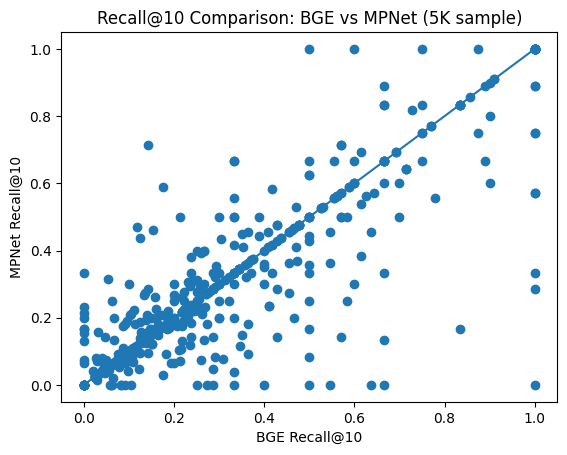

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---------- Helpers ----------
def normalize_rows(X: np.ndarray) -> np.ndarray:
    norms = np.linalg.norm(X, axis=1, keepdims=True)
    norms = np.where(norms == 0, 1.0, norms)
    return X / norms

def semantic_search_with_model(query: str, embed_model, doc_embs_norm: np.ndarray, products_df: pd.DataFrame, k: int = 10) -> pd.DataFrame:
    """
    Semantic search: embed query using embed_model, then cosine similarity with doc_embs_norm.
    Assumes doc_embs_norm is already L2-normalized (rows).
    """
    q_vec = embed_model.encode([query], normalize_embeddings=True)[0]  # normalized
    q_vec = np.asarray(q_vec, dtype=np.float32)
    sims = doc_embs_norm @ q_vec  # dot product = cosine similarity

    top_idx = np.argsort(-sims)[:k]
    out = products_df.iloc[top_idx].copy()
    out["score"] = sims[top_idx]
    out["rank"] = range(1, k + 1)
    out["query"] = query
    return out

# Ensure doc embeddings are numpy + normalized
emb_bge = np.asarray(emb_bge, dtype=np.float32)
emb_mpnet = np.asarray(emb_mpnet, dtype=np.float32)

# In case normalize_embeddings=True didn't normalize (usually it does), normalize once:
bge_docs = normalize_rows(emb_bge)
mpnet_docs = normalize_rows(emb_mpnet)

# ---------- 1) Compare results for specific queries ----------
test_queries = ["comfortable sofa", "star wars rug", "modern coffee table"]  # add more if you want

for q in test_queries:
    print("\n" + "="*80)
    print("Query:", q)

    bge_res = semantic_search_with_model(q, model_bge, bge_docs, loaded_products, k=5)
    mpnet_res = semantic_search_with_model(q, model_mpnet, mpnet_docs, loaded_products, k=5)

    print("\nBGE top 5:")
    display(bge_res[["rank", "product_id", "product_name", "product_class", "score"]])

    print("\nMPNet top 5:")
    display(mpnet_res[["rank", "product_id", "product_name", "product_class", "score"]])

# ---------- 2) Evaluate Recall@10 on filtered query set ----------
K = 10

sample_product_ids = set(loaded_products["product_id"].astype(int).tolist())

labels_in_sample = labels[labels["product_id"].isin(sample_product_ids)].copy()
labels_in_sample_relevant = labels_in_sample[labels_in_sample["grade"] > 0].copy()  # Partial+Exact

relevant_by_query = (
    labels_in_sample_relevant
    .groupby("query_id")["product_id"]
    .apply(lambda s: set(map(int, s.tolist())))
    .to_dict()
)

filtered_queries = queries[queries["query_id"].isin(relevant_by_query.keys())].copy()
print("\nTotal queries:", len(queries))
print("Filtered queries with >=1 relevant product in sample:", len(filtered_queries))

rows = []
for _, row in filtered_queries.iterrows():
    qid = int(row["query_id"])
    qtext = row["query"]
    relevant_ids = relevant_by_query[qid]

    bge_res = semantic_search_with_model(qtext, model_bge, bge_docs, loaded_products, k=K)
    mpnet_res = semantic_search_with_model(qtext, model_mpnet, mpnet_docs, loaded_products, k=K)

    bge_ids = bge_res["product_id"].astype(int).tolist()
    mpnet_ids = mpnet_res["product_id"].astype(int).tolist()

    rows.append({
        "query_id": qid,
        "query": qtext,
        "bge_recall@10": recall_at_k(bge_ids, relevant_ids, k=K),
        "mpnet_recall@10": recall_at_k(mpnet_ids, relevant_ids, k=K),
        "num_relevant_in_sample": len(relevant_ids),
    })

compare_df = pd.DataFrame(rows)

print("\nEvaluated queries:", len(compare_df))
print("Mean BGE Recall@10:", compare_df["bge_recall@10"].mean())
print("Mean MPNet Recall@10:", compare_df["mpnet_recall@10"].mean())

# Show biggest deltas (optional)
display(
    compare_df.assign(diff=compare_df["mpnet_recall@10"] - compare_df["bge_recall@10"])
              .sort_values("diff", ascending=False)
              .head(10)
)

# ---------- 3) Scatter plot ----------
plt.figure()
plt.scatter(compare_df["bge_recall@10"], compare_df["mpnet_recall@10"])
plt.title("Recall@10 Comparison: BGE vs MPNet (5K sample)")
plt.xlabel("BGE Recall@10")
plt.ylabel("MPNet Recall@10")

# Reference diagonal y=x
minv = float(np.nanmin([compare_df["bge_recall@10"].min(), compare_df["mpnet_recall@10"].min()]))
maxv = float(np.nanmax([compare_df["bge_recall@10"].max(), compare_df["mpnet_recall@10"].max()]))
plt.plot([minv, maxv], [minv, maxv])

plt.show()


---

## Task 6: Git Submission (5 points)

Submit your work using the Git workflow:

- [ ] Create a new branch called `homework-4`
- [ ] Commit your work with a meaningful message
- [ ] Push to GitHub
- [ ] Create a Pull Request
- [ ] Merge the PR to main
- [ ] Submit the `.ipynb` file on Blackboard

The TA will verify your submission by checking the merged PR on GitHub.